In [10]:
import numpy as np
import os
import torch

#Загрузка картинок в csv
random_seed = 4545435
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:

#  Создает в директории csv файл, размечающий картинки
def generate_csv_classes(file_name):
    file_csv = open(file_name, "w+")
    count_class = 0
    res = "filename, full_filename, num_class\n"
    for i in os.listdir("../resized_images"):
        for j in os.listdir("../resized_images"+os.sep+i):

            res += "{},{},{}\n".format(j.split(".")[0], "../resized_images"+os.sep+i+os.sep+j, count_class)
        count_class+=1
           
    file_csv.write(res)
    file_csv.close()
generate_csv_classes("sample.csv")

In [12]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class MyCustomDataset(Dataset):
    def __init__(self, dict_name):
        self.transformations = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        self.class_dict = pd.read_csv(dict_name)
        self.data_len = len(self.class_dict.index)
        
    def __getitem__(self, index):
        res_row = self.class_dict.iloc[index]
        full_filename = res_row[1]
        data = Image.open(full_filename).resize((128, 128))
        data = self.transformations(data)  # (3)
        label = res_row[2]
        return (data, label)

    def __len__(self):
        
        return self.data_len
        

In [13]:
data = MyCustomDataset("sample.csv")  # нужно указать csv файл

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
dataset_size = len(data)
indices = list(range(dataset_size))
validation_split = 0.6
split = int(np.floor(validation_split * dataset_size))

np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(data, batch_size=64,
                         num_workers=0, sampler=train_sampler)

val_loader = DataLoader(data, batch_size=64,
                         num_workers=0, sampler=valid_sampler)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
class MySimpleConvNet(nn.Module): 
    def __init__(self): 
        super(MySimpleConvNet, self).__init__() 
        self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(65536, 100) 
        self.fc2 = nn.Linear(100, 12)

    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

Epoch [2/10], Step [2/6], Loss: 1.4398, Accuracy: 46.88%


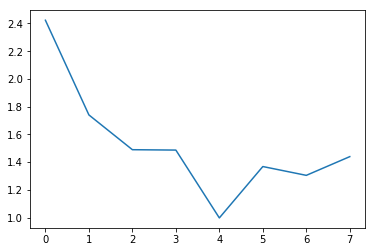

Epoch [2/10], Step [3/6], Loss: 1.3609, Accuracy: 59.38%


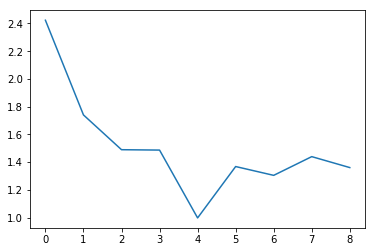

Epoch [2/10], Step [4/6], Loss: 0.9527, Accuracy: 65.62%


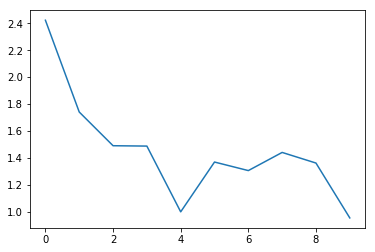

Epoch [2/10], Step [5/6], Loss: 1.1430, Accuracy: 57.81%


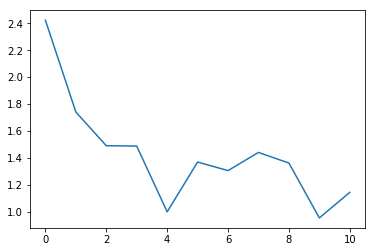

Epoch [2/10], Step [6/6], Loss: 1.2339, Accuracy: 65.38%


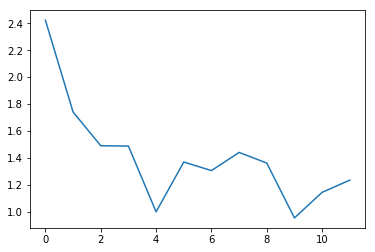

Epoch [3/10], Step [2/6], Loss: 1.2903, Accuracy: 53.12%


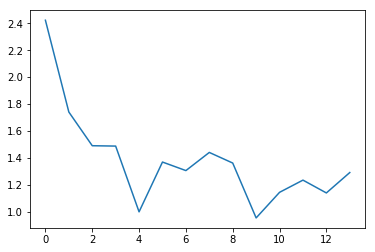

Epoch [3/10], Step [3/6], Loss: 1.2128, Accuracy: 48.44%


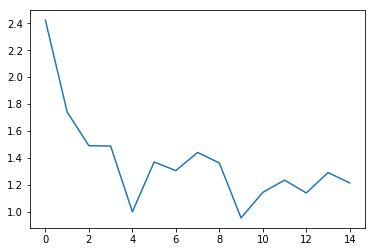

Epoch [3/10], Step [4/6], Loss: 1.1565, Accuracy: 56.25%


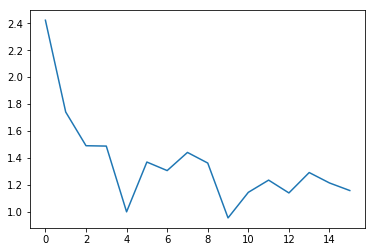

Epoch [3/10], Step [5/6], Loss: 1.2217, Accuracy: 64.06%


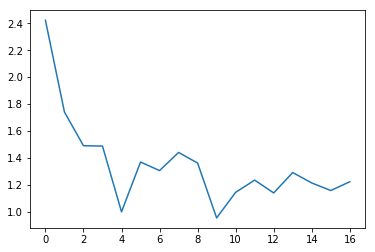

Epoch [3/10], Step [6/6], Loss: 0.9815, Accuracy: 80.77%


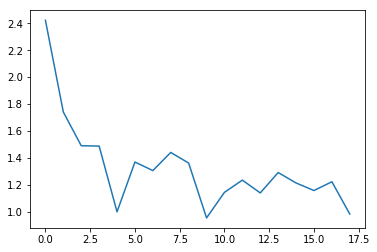

Epoch [4/10], Step [2/6], Loss: 1.2364, Accuracy: 56.25%


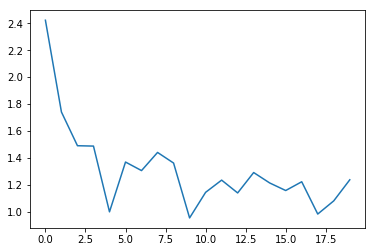

KeyboardInterrupt: 

In [9]:
import torch
import matplotlib.pyplot as plt
model = MySimpleConvNet()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.5)
total_step = len(train_loader)
loss_list = []
acc_list = []
num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Прямой запуск
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Обратное распространение и оптимизатор
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Отслеживание точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 1 == 0 and epoch != 0 and i != 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
            plt.figure()
            plt.plot(list(range(len(loss_list))), loss_list)
            plt.show()


In [ ]:
for i, (images, labels) in enumerate(val_loader):
    outputs = model(images)
    loss = criterion(outputs, labels)
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)
    print('Batch №{} Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(i, loss.item(),
                          (correct / total) * 100))